<a href="https://colab.research.google.com/github/vishva2410/Deep-Learning-Projects-Part-A-/blob/main/brain_cancer(classification_simple).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score,classification_report
import tensorflow as tf
from zipfile import ZipFile
import os
import warnings
warnings.filterwarnings('ignore')
import kagglehub
from keras.utils import to_categorical
import cv2
import random
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
print("Path to dataset files:", path)
y_p = os.path.join(path, 'yes')
n_p = os.path.join(path, 'no')

Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


In [3]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 1.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/26 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N26.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N5.jpg
/kaggle/input/brain-mri-images-for-b

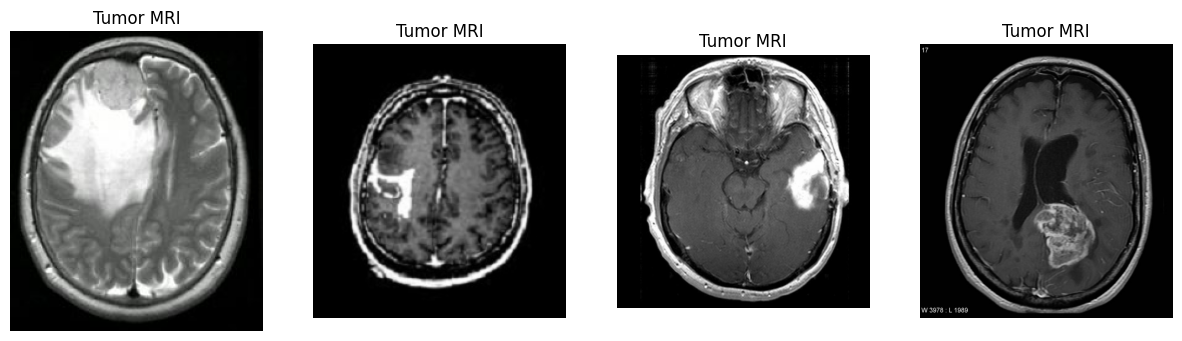

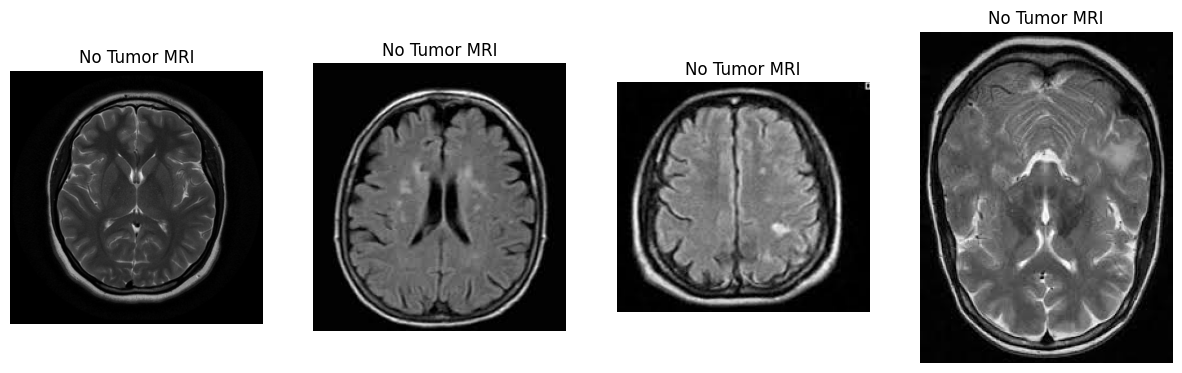

In [4]:
def show_images(folder, title, num_images=4):
    images = random.sample(os.listdir(folder), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(title)

    plt.show()

show_images(y_p, "Tumor MRI")
show_images(n_p, "No Tumor MRI")

In [5]:
IMG_SIZE = 128
def load_and_preprocess_data(directory, label):
    images = []
    labels = []
    for file in os.listdir(directory):
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        images.append(img)
        labels.append(label)
    return images, labels


In [6]:
tumor_dir = os.path.join(path, 'yes')
no_tumor_dir = os.path.join(path, 'no')

tumor_images, tumor_labels = load_and_preprocess_data(tumor_dir, 1)
no_tumor_images, no_tumor_labels = load_and_preprocess_data(no_tumor_dir, 0)


X = np.array(tumor_images + no_tumor_images)
y = np.array(tumor_labels + no_tumor_labels)

X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")

Training set: (202, 128, 128, 1), Labels: (202,)
Validation set: (51, 128, 128, 1), Labels: (51,)


In [7]:
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply((img * 255).astype(np.uint8)) / 255.0  # Convert back to 0-1 range

X_train = np.array([apply_clahe(img) for img in X_train])
X_val = np.array([apply_clahe(img) for img in X_val])

In [17]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')

])

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,731,649 (10.42 MB)

 Trainable params: 2,731,649 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(X_train, y_train, epochs=29, validation_data=(X_val, y_val))

Epoch 1/29
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5614 - loss: 0.7979 - val_accuracy: 0.6275 - val_loss: 0.6916
Epoch 2/29
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5638 - loss: 0.6890 - val_accuracy: 0.5294 - val_loss: 0.6914
Epoch 3/29
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6224 - loss: 0.6671 - val_accuracy: 0.5294 - val_loss: 0.6933
Epoch 4/29
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6109 - loss: 0.6758 - val_accuracy: 0.5294 - val_loss: 0.6781
Epoch 5/29
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6514 - loss: 0.6301 - val_accuracy: 0.5294 - val_loss: 0.6629
Epoch 6/29
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6671 - loss: 0.6124 - val_accuracy: 0.7451 - val_loss: 0.6262
Epoch 7/29
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7758 - loss: 0.5623 - val_accuracy: 0.7451 - val_loss: 0.5182
Epoch 8/29
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7512 - loss: 0.5370 - val_accuracy: 0.7647 - val_loss: 0.5169
E

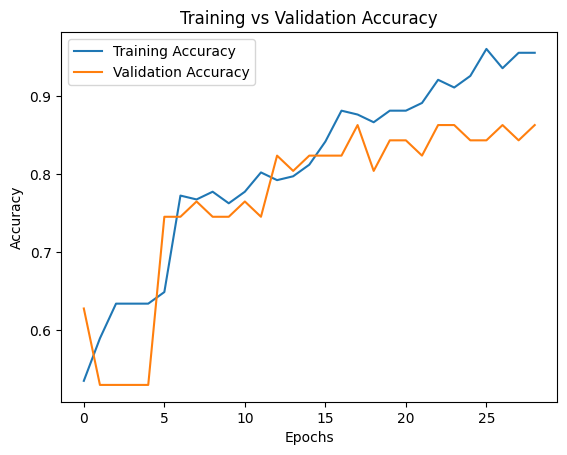

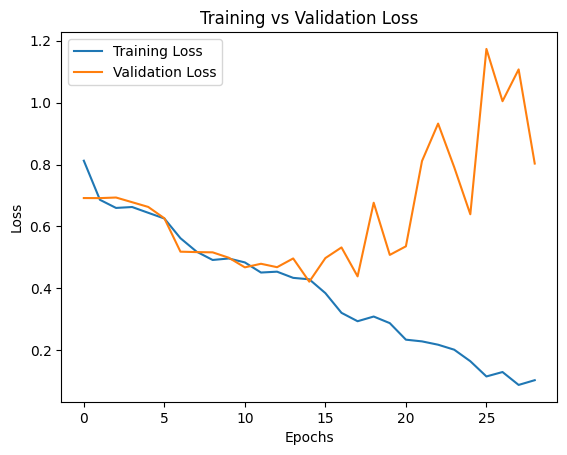

In [21]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

In [22]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step


In [25]:
print(classification_report(y_val, y_pred, target_names=["No Tumor", "Tumor"]))

              precision    recall  f1-score   support

    No Tumor       0.95      0.75      0.84        24
       Tumor       0.81      0.96      0.88        27

    accuracy                           0.86        51
   macro avg       0.88      0.86      0.86        51
weighted avg       0.88      0.86      0.86        51

